# Analiza podatkov o igrah na platformi Steam

V tej projektni nalogi bomo obdelali podatke o igrah na platformi [Steam](https://store.steampowered.com/), ter poskusili najti povezave med njimi. Podatke smo pridobili iz domače strani vsake igre, naložili pa smo najpopularnejših 10_000 iger. Po obdelavi podatkov je ostalo okoli 7000 iger (odstranjene so bile ponovitve, prazni vnosi in podobno).

Pobrani podatki o vsaki igri so (seveda občasno kakšen podatek tudi manjka):
* Naslov
* Opis
* Datum Izida
* Razvijalec
* Založnik
* Metascore
* Starostna ocena
* Agencija, ki je dodelila starostno oceno
* Uporabniške oznake
* Oznake vsebine
* Vsebinska opozorila
* Jeziki, ki jih igra podpira
* Polna cena igre
* Cena ob času prenosa podatkov
* Popust ob času prenosa podatkov
* Število vseh ocen
* Število pozitivnih ocen
* Opisna ocena
* Podatki o ocenah za zadnje časovno območje
* Podatki o sistemskih zahtevah

Podatke smo naložili s pomočjo knjižnice `requests`, jih izluščili z `BeautifulSoup` ter shranili v `csv` formatu. Obdelava bo potekala s pomočjo knjižnice `pandas`, proti koncu pa tudi `nltk` in `sklearn` za obdelavo besedila ter strojno učenje.

---
## Priprava na delo
Pripravimo okolje za delo, naložimo knjižnice, ki jih bomo potrebovali, ter nastavimo ostale Jupyter nastavitve.

In [1]:
# naložimo pakete
import pandas as pd
import numpy as np

import datetime
import re
from typing import List
from collections import Counter

import nltk
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle

import os

# ker bomo delali z velikimi razpredelnicami, povemo, da naj se vedno izpiše le 10 vrstic
pd.options.display.max_rows = 10

# izberemo interaktivni "notebook" stil risanja
%matplotlib notebook
%matplotlib inline

Naložimo tudi vse potrebne podatke, ki smo jih pridobili in grobo pripravili že prej.

In [2]:
game_data = pd.read_csv("data/game_data.csv", index_col="id")  # podatki o igrah
game_info = pd.read_csv("data/game_info.csv", index_col="id")  # podatki o oznakah iger
game_price = pd.read_csv("data/game_price.csv", index_col="id")  # podatki o cenah iger
game_languages = pd.read_csv("data/game_languages.csv", index_col="id")  # podatki, o jezikih, ki jih igra podpira
game_reviews = pd.read_csv("data/game_reviews.csv", index_col="id")  # podatki o ocenah
game_sysreq = pd.read_csv("data/game_sysreq.csv", index_col="id")  # podatki o sistemskih zahtevah

entities = pd.read_csv("data/entities.csv", index_col="id")  # podatki o razvijalcih/založnikih

---
## Priprava podatkov

Spodaj vidmo tabelo z glavnimi podatki o vsaki igri.

In [3]:
game_data

,title,description,date,dev_id,pub_id,metascore,age_rating,agency
id,,,,,,,,
1000010,Crown Trick,"Enter a labyrinth that moves as you move, wher...","16 Oct, 2020",0,1,83.0,NaN,NaN
1000030,"Cook, Serve, Delicious! 3?!","Cook, serve and manage your food truck as you ...","14 Oct, 2020",2,2,79.0,7.0,PEGI
1000080,Zengeon,Zengeon is an anime infused Action RPG and Rog...,"24 Jun, 2019",3,4,NaN,NaN,NaN
1000280,Tower of Origin2-Worm's Nest,As the protagonist，the Balrog Princess— HongYe...,"11 Jul, 2020",5,5,NaN,NaN,NaN
1000360,Hellish Quart,"A physics based, realistic, 3D sword dueling g...","16 Feb, 2021",6,6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
999020,Mega Man Zero/ZX Legacy Collection,Mega Man Zero/ZX Legacy Collection brings toge...,"25 Feb, 2020",1852,1852,NaN,12.0,PEGI
999220,Amnesia: Rebirth,A first-person horror adventure. Uncover your ...,"20 Oct, 2020",2623,2623,80.0,18.0,PEGI
999260,FOR HONOR™ - Year 3 Pass,NaN,"18 Dec, 2018",1655,-1,NaN,18.0,PEGI


V tej tabeli imamo stolpec datuma izida igre, ki ga pretvorimo v `datetime` objekt, da bomo z njim lažje delali. Ker graf gostote podatkov (`hexbin`) ne podpira `datetime` objekta, shranimo tudi leto. Ta format združuje podatke, zato ne potrebujemo boljše resolucije kot je eno leto.

In [4]:
def to_date(date_str):
    try:
        return datetime.datetime.strptime(date_str, "%d %b, %Y")
    except (ValueError, TypeError):  # če datuma ni
        return np.nan

def get_year(date: datetime.datetime):
    if date != date:
        return np.nan
    return date.year

game_data["date"] = game_data["date"].apply(to_date)
game_data["year"] = game_data["date"].apply(get_year)

Pomemben del so tudi ocene.

In [5]:
game_reviews

,total_recent,positive_recent,mood_recent,total_all,positive_all,mood_all
id,,,,,,
1000010,25,22,Very Positive,3641,3131,Very Positive
1000030,0,0,Very Positive,1160,1113,Overwhelmingly Positive
1000080,0,0,NaN,1153,818,Mostly Positive
1000280,0,0,NaN,18,14,Positive
1000360,99,92,Very Positive,2589,2433,Very Positive
...,...,...,...,...,...,...
999020,0,0,NaN,1029,812,Mostly Positive
999220,117,91,Mostly Positive,4975,3830,Mostly Positive
999260,0,0,NaN,137,104,Mostly Positive


Pri ocenah imamo na razpolago le število pozitivnih ter vseh ocen, ampak ker se slednje precej razlikuje od igre do igre, za vsako izračunamo delež pozitivnih ocen (tako v zadnjem času kot na splošno). Le-te bomo lažje primerjali med seboj.

In [6]:
recent_reviews = game_reviews["positive_recent"]/game_reviews["total_recent"]
all_reviews = game_reviews["positive_all"]/game_reviews["total_all"]
reviews = pd.DataFrame({"recent_score": recent_reviews, "all_score": all_reviews}).round(2)
game_reviews = game_reviews.join(reviews)

---
## Obdelava podatkov
### Opisne ocene iger

Na začetku vidimo, da ima vsaka ocena tudi opisni tip, za katerega sklepam, da je neposredno povezan z deležem pozitivnih ocen. To lahko preverimo tako, da za vsako opisno oceno poiščemo največji in najmanjši delež pozitivnih ocen, nato pa te primerjamo med seboj.

Hkrati preštejemo tudi število ponovitev vsake opisne ocene.

In [7]:
def get_bounds(time):
    time_max = game_reviews[[f"mood_{time}", f"{time}_score"]].groupby(f"mood_{time}").max().sort_values(f"{time}_score")
    time_max.columns = ["max"]
    time_min = game_reviews[[f"mood_{time}", f"{time}_score"]].groupby(f"mood_{time}").min().sort_values(f"{time}_score")
    time_min.columns = ["min"]
    time_bounds = time_min.join(time_max).dropna()  # odstranimo vrednosti brez podatkov

    time_counts = game_reviews[f"mood_{time}"].value_counts()

    time_bounds = time_bounds.join(time_counts)

    time_bounds.columns = ["min", "max", "count"]

    return time_bounds

In [8]:
recent_bounds = get_bounds("recent")

In [9]:
all_bounds = get_bounds("all")

In [10]:
recent_bounds

,min,max,count
mood_recent,,,
Very Negative,0.10,0.17,5
Mostly Negative,0.14,0.37,34
Mixed,0.33,0.69,361
Mostly Positive,0.64,0.79,366
Very Positive,0.73,0.98,2169
Overwhelmingly Positive,0.94,0.99,236


In [11]:
all_bounds

,min,max,count
mood_all,,,
Overwhelmingly Negative,0.11,0.13,3
Negative,0.12,0.17,3
Very Negative,0.14,0.19,6
Mostly Negative,0.18,0.39,80
Mixed,0.35,0.69,1029
Mostly Positive,0.64,0.79,1257
Positive,0.73,0.96,639
Very Positive,0.79,0.99,3607
Overwhelmingly Positive,0.95,0.99,581


Iz tabel vidimo, da so opisne ocene res odvisne od deleža pozitivnih ocen, saj tako spodnje kot zgornje meje strogo naraščajo hkrati z opisnimi ocenami*. 

Lahko pa tudi opazimo, da delež pozitivnih ocen ni edina stvar, ki vpliva na opisno oceno, saj je zgornja meja za neko opisno oceno višja od spodnje meje naslednje opisne ocene. To pomeni, da obstaja še neka skrita metrika, ki razloči ocene v teh primerih. Ena izmed možnosti za to bi lahko bila časovna razporejenost ocen, torej starejša kot je neka ocena, manj prinese k skupni vsoti. 

\* Pri opisnih ocenah opazimo manjšo anomalijo: opisna ocena `Negative` je bolj ekstremna kot `Very negative`, v drugi smeri pa je ravno obratno, `Very positive` je bolj ekstremna kot `Positive`. Razlogov za to je lahko veliko, najverjetnejši pa se mi zdi, da ker obstaja precej manj iger z negativnimi ocenami, skrite metrike precej bolj vplivajo na dejansko stanje.

---
### Primerjanje razvijalcev in založnikov

Naslednja statistika, ki jo lahko pogledamo, je "Kateri razvijalci/založniki (developers/publishers) imajo najbolje ocenjene igre?". Za to lahko za vsakega razvijalca/založnika izračunamo povprečje deleža pozitivnih ocen po vseh njegovih igrah. Poleg tega lahko še preštejemo število vseh takih iger, da lahko ločimo med razvijalcem, ki je razvil eno uspešno igro, in založnikom, ki redno objavlja uspešnice.

In [12]:
def ent_info(ent):
    ent_ratings = pd.DataFrame({ent: game_data[f"{ent}_id"], "score": game_reviews["all_score"]})
    ent_ratings = ent_ratings[ent_ratings[ent] != -1]  # odstranimo igre brez podatka o razvijalcu/založniku
    ent_grouped = ent_ratings.groupby(ent)

    ent_count = ent_grouped.count()
    ent_count.rename(columns={"score": "count"}, inplace=True)

    ent_score = ent_grouped.mean()

    ent_names = entities.copy()
    ent_names.index.names = [ent]

    return ent_score.join([ent_count, ent_names])



In [13]:
dev_info = ent_info("dev")
dev_info[dev_info["count"] > 3].sort_values("score", ascending=False)

,score,count,name
dev,,,
636,0.970000,5.0,Fireproof Games
3447,0.967500,4.0,Quiet River
2502,0.964000,5.0,The Behemoth
1266,0.958182,11.0,Valve
2883,0.957500,8.0,VisualArts/Key
...,...,...,...
2523,0.522000,5.0,Sledgehammer Games
657,0.512500,12.0,Gaijin Entertainment
104,0.510000,6.0,Visual Concepts


Tako vidimo, da je (po tem našem kriteriju) najboljši razvijalec iger podjetje `Fireproof games`, ki imajo 5 iger s povprečno oceno kar 0.97.

Najslabši razvijalec pa je `Round8 Studio`, čigar povprečna ocena iger pade celo pod 0.5.

<AxesSubplot:xlabel='Število iger razvijalca', ylabel='Delež pozitivnih ocen'>

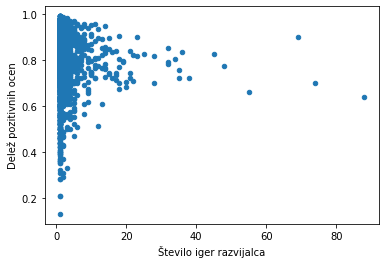

In [14]:
dev_info.plot(x="count", y="score", kind="scatter", ylabel="Delež pozitivnih ocen", xlabel="Število iger razvijalca")

Ker imamo relativno veliko iger, se bodo marsikatere točke prekrivale. Zato lahko dodatno narišemo še gostotni graf (hexbin), da vidimo, kje je zbranih največ iger. Tudi gostoto rišemo v logaritemski skali, in spremenimo barvno lestvico.

<AxesSubplot:xlabel='Število iger razvijalca', ylabel='Delež pozitivnih ocen'>

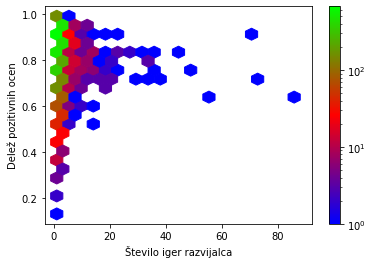

In [15]:
dev_info.plot.hexbin(x="count", y="score", gridsize=20, ylabel="Delež pozitivnih ocen", xlabel="Število iger razvijalca", bins="log", cmap="brg", sharex=False)

Če na graf narišemo oceno v odvisnosti od števila izdanih iger, opazimo, da imajo razvijalci z več igrami v splošnem relativno visoko povprečno oceno, ampak to pa še ne pomeni, da manj iger pomeni slabšo oceno. Še vedno se velika večina razvijalcev nahaja v zgornjem levem kotu, kar pomeni relativno malo, a kvalitetne igre.

In [16]:
pub_info = ent_info("pub")
pub_info[pub_info["count"] > 3].sort_values("score", ascending=False)

,score,count,name
pub,,,
1053,0.970000,5.0,New Blood Interactive
636,0.970000,5.0,Fireproof Games
3447,0.967500,4.0,Quiet River
3340,0.965000,4.0,VisualArts
2502,0.964000,5.0,The Behemoth
...,...,...,...
1881,0.576000,5.0,"USERJOY Technology Co.,Ltd."
554,0.574286,7.0,Bungie
1875,0.558000,5.0,WASABI entertainment


Pri založnikih je zgodba podobna. Prvo mesto si tokrat delita dva. Na vrhu je `New Blood Interactive`, s 5 igrami, katerih povprečna ocena je 0.97, družbo pa mu dela `Fireproof games`, ki je svojo izjemno serijo - `The Room` - očitno izdal v samozaložništvu.

Na drugi strani lestvice imamo `NetEase Games Montréal`, ki so s svojimi 4 igrami tik pod povprečno oceno 0.5.

<AxesSubplot:xlabel='Število iger založnika', ylabel='Delež pozitivnih ocen'>

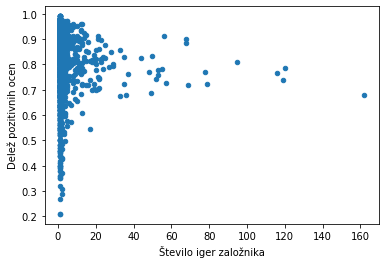

In [17]:
pub_info.plot(x="count", y="score", kind="scatter", ylabel="Delež pozitivnih ocen", xlabel="Število iger založnika")

<AxesSubplot:xlabel='Število iger založnika', ylabel='Delež pozitivnih ocen'>

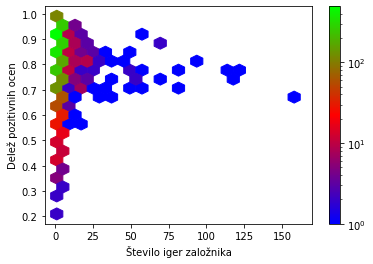

In [18]:
pub_info.plot.hexbin(x="count", y="score", gridsize=20, ylabel="Delež pozitivnih ocen", xlabel="Število iger založnika", bins="log", cmap="brg", sharex=False)

V splošnem lahko pri založnikih potegnemo podobne zaključke kot pri razvijalcih, kar se tiče povprečne ocene njihovih iger, z edino razliko, da imajo založniki pod sabo v povprečju več iger kot razvijalci, kar je povsem smiselno.

In [19]:
dev_info["count"].mean(), pub_info["count"].mean()

(1.8229837670703426, 2.532564197990324)

Naše opažanje iz grafov je tako potrjeno. 

---
### Povezava med ceno igre in njeno uporabniško oceno

Naslednja hipoteza, ki smo jo postavili je:

**Ljudje bodo raje ocenili dražje igre**

Za to bomo na grafu primerjali število vseh ocen ter ceno igre. Poleg tega lahko še primerjamo delež pozitivnih ocen s ceno igre, da vidimo, ali je mnenje ljudstva, da so dražje igre boljše. 

Da lahko to dosežemo, združimo delež pozitivnih ocen, število vseh ocen, in ceno vsake igre. Pri tem uporabimo le vnose tipa `M` (saj so to cene za samo igro, in ne za kakšne dodane vsebine) ter polno ceno, brez popustov. Kjer cene ni, ali pa je le-ta `"Free"` bomo to nadomestili s ceno 0.

In [20]:
def extract_price(price):
    if price != price or price == "Free":  # s prvim testom preverimo ali je cena `nan`
        return 0
    return float(price[:-1].replace(",", ".").replace("-", "0"))  # odstranimo valuto, spremenimo decimalno vejico v piko, ter popravimo format "10,--€"


full_prices = game_price[(game_price["type"] == "M")][["original"]]
full_prices["cost"] = full_prices["original"].apply(extract_price)
full_prices.drop("original", axis=1, inplace=True)
price_reviews = full_prices.join(game_reviews[["total_all", "all_score"]])

<AxesSubplot:xlabel='Cena igre [€]', ylabel='Število vseh ocen'>

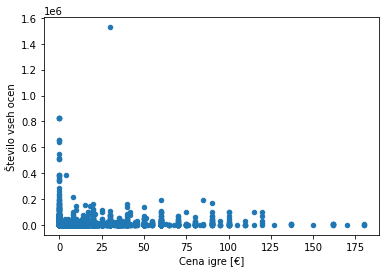

In [87]:
price_reviews.plot(x="cost", y="total_all", kind="scatter", xlabel="Cena igre [€]", ylabel="Število vseh ocen")

Na grafu števila ocen v odvisnosti od cene vidimo, da so vse cene zbrane precej pri dnu, ker obstaja igra, ki ima neprimerljivo več ocen kot vse ostale igre, zato ordinatno os predstavimo v logaritemski skali.

<AxesSubplot:xlabel='Cena igre [€]', ylabel='Število vseh ocen'>

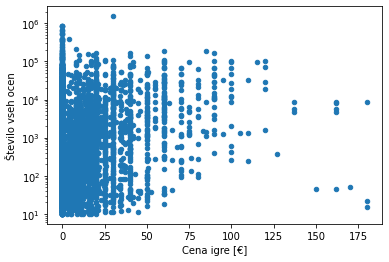

In [86]:
price_reviews.plot(x="cost", y="total_all", kind="scatter", logy=True, xlabel="Cena igre [€]", ylabel="Število vseh ocen")

<AxesSubplot:xlabel='Cena igre [€]', ylabel='Število vseh ocen'>

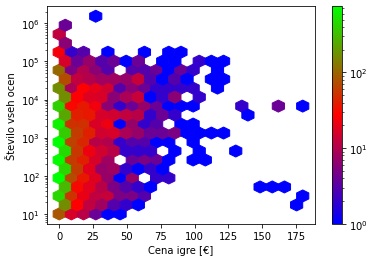

In [85]:
price_reviews[price_reviews["total_all"]>0].plot.hexbin(x="cost", y="total_all", gridsize=20, yscale="log", xlabel="Cena igre [€]", ylabel="Število vseh ocen", bins="log", cmap="brg", sharex=False)

Tudi po tej spremembi vidimo, da število ocen ni neposredno povezano s ceno, vidimo pa, da so cenejše igre ocenjene precej večkrat, kar je smiselno, saj bodo imele precej več igralcev. Da bi našo hipotezo izboljšali, bi bilo bolje, če bi gledali delež igralcev, ki so igro ocenili, za to pa bi potrebovali število vseh igralcev. Na žalost tega podatka nimamo, zato z analizo v tej smeri ne moremo nadaljevati.

<AxesSubplot:xlabel='Cena igre [€]', ylabel='Delež pozitivnih ocen'>

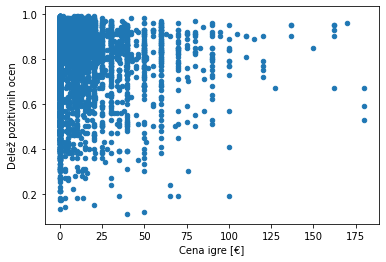

In [84]:
price_reviews.plot(x="cost", y="all_score", kind="scatter", xlabel="Cena igre [€]", ylabel="Delež pozitivnih ocen")

<AxesSubplot:xlabel='Cena igre [€]', ylabel='Delež pozitivnih ocen'>

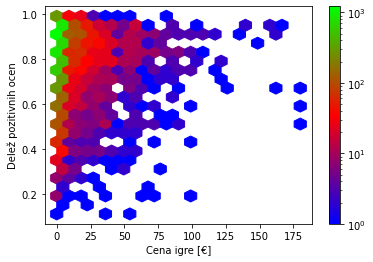

In [83]:
price_reviews.plot.hexbin(x="cost", y="all_score", gridsize=20, ylabel="Delež pozitivnih ocen", xlabel="Cena igre [€]", bins="log", cmap="brg", sharex=False)

Na grafu deleža pozitivnih ocen vidimo da, poleg nekaj izjem, najnižji delež pozitivnih ocen s ceno narašča, kar pomeni da **dražja kot je igra, manj verjetna je slaba ocena**. Seveda to ne pomeni, da če želimo dobro ocenjeno igro, moramo dvigniti ceno, ampak sta oba podatka verjetno posledica česa drugega, recimo truda, vloženega v razvoj oz. kvalitete igre. Bolj kot je igra kvalitetna, višje ocene bo imela, hkrati pa bo razvijalec (oz. založnik) raje postavil višjo ceno.

---
### Ali kritiki res povzamejo mnenje igralcev?

Marsikdo pred nakupom igre prebere mnenja kritikov, da izvejo ali jim bo igra všeč. V kolikšni meri pa sploh lahko povprečni igralec zaupa kritikom?

In [26]:
meta_score = game_data[["metascore"]].join(game_reviews[["all_score"]])

<AxesSubplot:xlabel='Delež pozitivnih ocen', ylabel='metascore'>

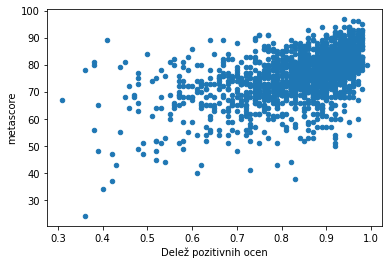

In [27]:
meta_score.plot(x="all_score", y="metascore", kind="scatter", xlabel="Delež pozitivnih ocen")

<AxesSubplot:xlabel='Delež pozitivnih ocen', ylabel='metascore'>

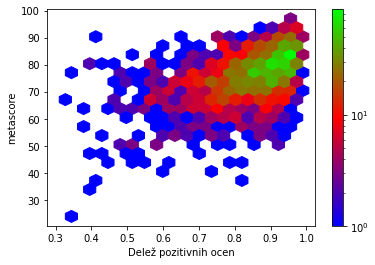

In [67]:
meta_score.plot.hexbin(x="all_score", y="metascore", gridsize=20, xlabel="Delež pozitivnih ocen", bins="log", cmap="brg", sharex=False)

In [68]:
meta_score.corr()

,metascore,all_score
metascore,1.000000,0.500016
all_score,0.500016,1.000000


Na grafu sicer vidimo, da je velik del točk zbranih v zgornjem desnem kotu, njihova korelacija pa je samo 0.5. Ocene kritikov ter igralcev torej niso popolnoma nepovezane, se pa njihova mnenja še vedno precej razlikujejo. 

---
### Oznake iger

Videli smo, kateri razvijalci ter založniki imajo najbolje ocenjene igre. Kako pa je z oznakami iger? Na voljo imamo tri tipe oznak:
* [T] Uporabniške oznake (user tags), ki jih lahko dodelijo uporabniki sami, ter vsebujejo podatke o vsebini igre,
* [C] Oznake lastnosti (content tags), ki jih dodelijo razvijalci/založniki ali pa platforma, ter vsebujejo podatke o tehničnih lastnostih igre, ter
* [R] Oznake vsebine (Rating tags), ki jih dodeli posebna agencija (kot je recimo PEGI) in vsebujejo opozorilne oznake o temah igre

Za vsako od teh oznak lahko izračunamo povprečno vrednost deleža pozitivnih ocen za vse igre s to oznako, ki jih nato lahko razvrstimo. 

In [30]:
def rate_tags(tag_type, ascending=True):
    tags = game_info[game_info["type"] == tag_type][["tag"]]
    return tags.join(game_reviews[["all_score"]]).groupby("tag").mean().round(2).sort_values("all_score", ascending=ascending)

In [31]:
rate_tags("T")

,all_score
tag,
Spelling,0.44
Basketball,0.67
MMORPG,0.69
Massively Multiplayer,0.71
Spaceships,0.71
...,...
Minimalist,0.91
Touch-Friendly,0.92
Mini Golf,0.92


Od tukaj lahko razberemo, da so najmanj priljubljene tiste igre, ki imajo oznako "spelling", najbolj pa tiste, z oznakami "8-bit music" ter "Rock music". 

In [32]:
rate_tags("C")

,all_score
tag,
MMO,0.67
Downloadable Content,0.75
In-App Purchases,0.75
Cross-Platform Multiplayer,0.77
Steam Turn Notifications,0.77
...,...
Remote Play on Phone,0.87
Commentary available,0.87
Additional High-Quality Audio,0.90


Najmanj priljubljena lastnost iger je MMO, zelo nizko pa sta tudi oznaki "Downloadable Content" in "In-App purchases", ki obe sporočata, da z nakupom igre nismo dobili vsega, in bomo za polno izkušnjo morali še dodatno plačati. Na drugi strani imamo oznako "Includes Source SDK", ki razvijalcem močno olajša pisanje modifikacij ter razširitev za igro. Zelo visoko je tudi oznaka "Additional High Quality Audio"; očitno imajo uporabniki zelo radi dober zvok oz. glasbo, tako tukaj kot pri uporabniških oznakah je namreč zvok oz. glasba v samem vrhu.

In [33]:
rate_tags("R")

,all_score
tag,
"Violence, online gameplay",0.40
\nGambling,0.41
"Bad language, Violence",0.47
In-Game Purchases(Includes Random Items,0.47
In-Game Purchases,0.47
...,...
Lyrics,NaN
Mild Fantasy Violence\nLyrics\nMusic Downloads Not Rated by PEGI,NaN
Music Downloads Not Rated by PEGI,NaN


Pri oznakah vsebine pa vidimo, da oznake niso standardizirane, kar pomeni, da na žalost o njih ne moremo povedati kaj dosti. Namesto njih uporabimo starostno mejo ter pogledamo, koliko iger ima kakšno oznako.

<AxesSubplot:ylabel='Število iger s starostno oceno'>

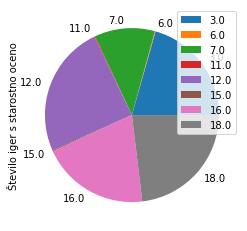

In [72]:
game_data.groupby("age_rating").count().plot(y="title", kind="pie", ylabel="Število iger s starostno oceno")

Opazimo, da so oznake dokaj enakomerno razporejene, z izjemo iger, ki imajo spodnjo starostno mejo 6, 11 in 15 let, ki jih je precej manj. Sklepam, da jih je tako malo zato, ker so vse le eno leto nižje od neke druge obstoječe starostne meje, tako da se pri večini iger raje odločijo za slednjo.

---
 ### Ali postajajo igre s časom bolj sistemsko požrešne?

V spodnji tabeli so napisane vse sistemske zahteve, ki jih razvijalci priporočajo oz. zahtevajo.

Kadar v tem delu govorimo o odvisnosti ene spremenljivke od časa, predvsem o naraščanju s časom, se osredotočamo na zgornjo ovojnico grafa. Razvijalci lahko vedno naredijo igro manj računsko zahtevno ali cenejšo kot so ostale igre.

In [34]:
game_sysreq

,OS,CPU,RAM,Graphics,DirectX,Disk Space,Additional,type
id,,,,,,,,
1000010,Windows 7 (32-bit Version),Intel Core(TM) i3-4160 / AMD X4 830,4 GB RAM,NVIDIA GeForce GTX 650 / AMD R7 350,Version 11,2 GB available space,NaN,M
1000010,Windows 7 (64-bit Version),Intel Core(TM) i5-7500 / AMD Ryzen 3 1300X,8 GB RAM,NVIDIA GeForce GTX 750 / AMD R7 360,Version 11,2 GB available space,NaN,R
1000030,Windows 7/8/10+,NaN,4 GB RAM,GPU with at least 256MB of VRAM,NaN,1200 MB available space,Minimum resolution of 1280x720 required,M
1000030,Windows 7/8/10+,NaN,8 GB RAM,GPU with at least 512MB of VRAM or better,NaN,1200 MB available space,Minimum resolution of 1280x720 required,R
1000080,Windows7 / Windows8 / Windows10,2.5Ghz,4 GB RAM,GT710,Version 11,3 GB available space,NaN,M
...,...,...,...,...,...,...,...,...
999260,"Windows 7, Windows 8.1, Windows 10 (64-bit ver...",Intel Core i5-2500K | AMD FX-6350 or equivalent,8 GB RAM,NVIDIA GeForce GTX770/GTX970/GTX1060 with 3 GB...,NaN,40 GB available space,Mouse and Keyboard supported. Game contains Ea...,R
999550,Windows 8.1 (64-bit only),AMD FX-8320/Intel Core i3-4160,4 GB RAM,AMD Radeon 7570/nVidia GeForce GTX 650 1GB,Version 9.0c,2 GB available space,NaN,M
999550,Windows 10 (64-bit only),AMD FX-8350/Intel Core i7-6700,8 GB RAM,AMD Radeon R9/nVidia GeForce GTX 970 4GB,Version 9.0c,2 GB available space,NaN,R


Pri sistemskih zahtevah sicer imamo podatke o marsičem, a jih veliko ne moremo primerjati med seboj. Kako naj bi recimo med seboj primerjali `"2.33 GHz Quad Core or Greater"` in `"Intel Core i3-2100 or AMD FX-4350"`?\* Imamo pa dva precej lepa podatka, namreč priporočen pomnilnik ("RAM") in prazen prostor na disku ("Disk Space"). Pri obeh moramo paziti, ker so enote lahko ali GB ali pa MB.

\* Če bi imeli način, da vsaki komponenti dodelimo številčno "moč", bi to lahko naredili brez problemov. Lahko bi uporabili kakšno stran kot je [3D mark](https://www.3dmark.com/), ampak bi bilo pobiranje teh podatkov lahko projektna naloga sama po sebi.

In [35]:
def extract_number(req):
    ptrn = re.compile(r"(\d+) (MB|GB)")
    mtch = ptrn.match(req.upper())
    if mtch is None:
        return np.nan
    size, scale = mtch.groups()
    fac = 1000 if scale == "MB" else 1
    return float(size)/fac

game_size = game_sysreq[game_sysreq["type"] == "R"][["RAM", "Disk Space"]].applymap(extract_number, na_action="ignore")

Ena izmed zelo opaznih sprememb je verjetno dvig zahtev s časom. Pričakovali bi, da se dvigata eksponentno, tako kot pravi Moorov Zakon.

#### Pomnilnik skozi čas

<AxesSubplot:xlabel='Datum izida', ylabel='RAM'>

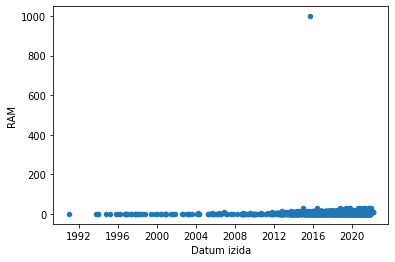

In [36]:
time_size = game_data[["date"]].join(game_size)
time_size.plot(x="date", y="RAM", kind="scatter", xlabel="Datum izida", ylabel="RAM")

Očitno neka igra zahteva 1000 GB pomnilnika. Poglejmo, katera igra je to.

In [37]:
time_size[time_size["RAM"] > 500]

,date,RAM,Disk Space
id,,,
391570,2015-09-15,999.0,1.0


In [38]:
game_data.loc[391570]

title          UNDERTALE Soundtrack
description                     NaN
date            2015-09-15 00:00:00
dev_id                         3136
pub_id                           -1
metascore                       NaN
age_rating                      NaN
agency                          NaN
year                         2015.0
Name: 391570, dtype: object

In [39]:
game_sysreq.loc[391570]

,OS,CPU,RAM,Graphics,DirectX,Disk Space,Additional,type
id,,,,,,,,
391570,Any,Sure,1 MB RAM,"Well, it's just music files...",NaN,1 GB available space,It's just music files.,M
391570,Windows 90000000,Very fast processor that can play 9000 songs p...,999 GB RAM,Special Graphics Card That Makes Music Look Li...,NaN,1 GB available space,"Really though, it's just music files...",R


Po imenu sodeč gre za glasbo igre Undertale in razvijalca s smislom za humor. Izločimo to točko in poskusimo še enkrat.

<AxesSubplot:xlabel='Datum izida', ylabel='RAM'>

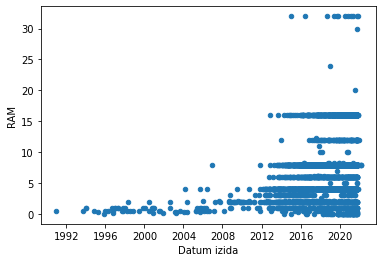

In [40]:
time_size = time_size[time_size["RAM"] < 500]
time_size.plot(x="date", y="RAM", kind="scatter", xlabel="Datum izida")

To bi lahko bilo eksponentno naraščanje, zato narišimo še graf z logaritemsko skalo.

<AxesSubplot:xlabel='Datum izida', ylabel='RAM'>

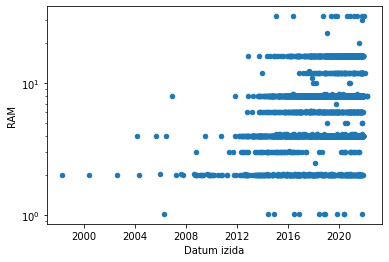

In [41]:
time_size[time_size["RAM"] > 1].plot(x="date", y="RAM", kind="scatter", logy=True, xlabel="Datum izida")  # filtriramo na več kot 1, ker nas zanima le zgornja ovojnica, vrednosti manjše kot 1 pa lahko pokvarijo logaritemsko skalo.

Res, zgornje točke ležijo, vsaj približno, na premici. To potrdi našo domnevo o eksponentnem naraščanju. Vidimo tudi da se okoli leta 2014 naraščanje ustavi pri 32 GB, najverjetneje zato, ker ima še dandanes le redkokdo več pomnilnika.

#### Poraba diska skozi čas
Kako pa je s potrebnim praznim prostorom na disku za namestitev posamezne igre?

<AxesSubplot:xlabel='Datum izida', ylabel='Potreben prazen prostor na disku'>

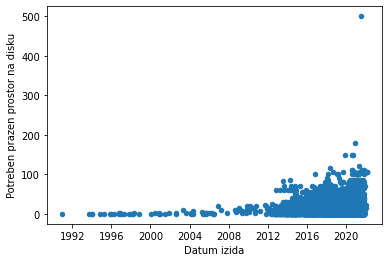

In [42]:
time_size.plot(x="date", y="Disk Space", kind="scatter", xlabel="Datum izida", ylabel="Potreben prazen prostor na disku")

Tudi tukaj izgleda, da ena igra izstopa:

In [43]:
time_size[time_size["Disk Space"] > 400]

,date,RAM,Disk Space
id,,,
1675930,2021-07-09,0.008,500.0


In [44]:
game_data.loc[1675930]

title          OhShape - Caravan Palace Music Pack
description                                    NaN
date                           2021-07-09 00:00:00
dev_id                                         605
pub_id                                         605
metascore                                      NaN
age_rating                                     NaN
agency                                         NaN
year                                        2021.0
Name: 1675930, dtype: object

In [45]:
game_sysreq.loc[1675930]

,OS,CPU,RAM,Graphics,DirectX,Disk Space,Additional,type
id,,,,,,,,
1675930,Windows 10,Intel Core i5 Sandy Bridge or equivalent,8 GB RAM,NVIDIA GTX 1050Ti / AMD Radeon RX 470 or greater,NaN,500 GB available space,NaN,M
1675930,Windows 10,Intel Core i5-4590 equivalent or greater,8 MB RAM,NaN,NaN,500 GB available space,NaN,R


Tudi tukaj gre za neko dodatno glasbo. Spet odstranimo ekstremno točko ter poglejmo situacijo brez nje.

<AxesSubplot:xlabel='Datum izida', ylabel='Potreben prazen prostor na disku'>

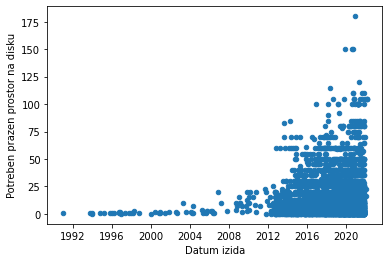

In [46]:
time_size = time_size[time_size["Disk Space"] < 400]
time_size.plot(x="date", y="Disk Space", kind="scatter", xlabel="Datum izida", ylabel="Potreben prazen prostor na disku")

<AxesSubplot:xlabel='Datum izida', ylabel='Potreben prazen prostor na disku'>

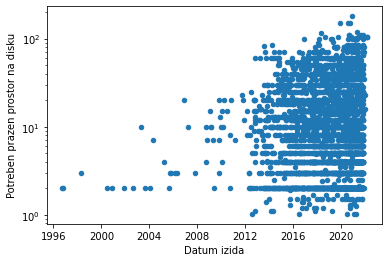

In [47]:
time_size[time_size["Disk Space"] > 1].plot(x="date", y="Disk Space", kind="scatter", logy=True, xlabel="Datum izida", ylabel="Potreben prazen prostor na disku")

Tudi tukaj vidimo premico, celo lepšo kot v prejšnjem primeru. Velikost iger torej prav tako narašča eksponentno.

#### Cena igre in uporabniška ocena skozi čas

Pogledali smo odvisnost zahtevane količine pomnilnika in velikosti diska s časom, kako pa se s časom spreminja število ocen in delež pozitivnih ocen? Kaj pa cena iger?

<AxesSubplot:xlabel='Datum izida', ylabel='Delež pozitivnih ocen'>

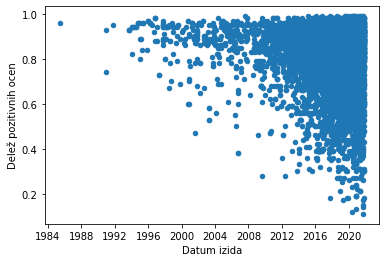

In [75]:
time_price_reviews = price_reviews.join(game_data[["date", "year"]])
time_price_reviews.plot(x="date", y="all_score", kind="scatter", xlabel="Datum izida", ylabel="Delež pozitivnih ocen")

<AxesSubplot:xlabel='Datum izida', ylabel='Delež pozitivnih ocen'>

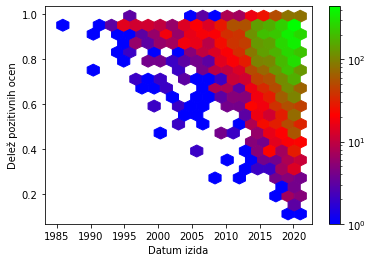

In [76]:
time_price_reviews.plot.hexbin(x="year", y="all_score", xlabel="Datum izida", ylabel="Delež pozitivnih ocen", gridsize=20, bins="log", cmap="brg", sharex=False)

Pri oceni lahko potrdimo mnenje marsikaterega igralca, da so starejše igre boljše. Sicer so vedno obstajale igre z dobrimi ocenami, ampak s časom se je število iger s slabšimi ocenami povečevalo. Najverjetnejši razlog za to se mi zdi dejstvo, da s časom postaja razvoj iger vse lažji, dandanes obstajajo orodja, kjer lahko nekdo skorajda brez predznanja že v kakšni uri naredi svojo videoigro in jo objavi na platformi. Seveda hitrost in enostavnost ne prideta zastonj, v večini primerov zato trpi kakovost. Včasih so imeli dostop tako do opreme kot znanja za razvoj igre le redki, po večinoma studii z več zaposlenimi, ki so se z razvojem iger ukvarjali profesionalno.

<AxesSubplot:xlabel='Datum izida', ylabel='Število vseh ocen'>

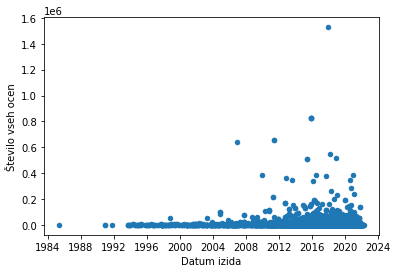

In [49]:
time_price_reviews.plot(x="date", y="total_all", kind="scatter", xlabel="Datum izida", ylabel="Število vseh ocen")

<AxesSubplot:xlabel='Datum izida', ylabel='Število vseh ocen'>

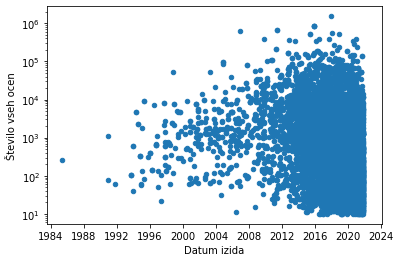

In [50]:
time_price_reviews.plot(x="date", y="total_all", kind="scatter", logy=True, xlabel="Datum izida", ylabel="Število vseh ocen")

<AxesSubplot:xlabel='Datum izida', ylabel='Število vseh ocen'>

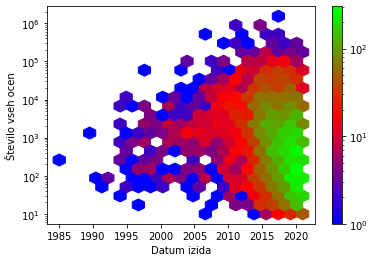

In [79]:
time_price_reviews[time_price_reviews["total_all"] > 1].plot.hexbin(x="year", y="total_all", xlabel="Datum izida", ylabel="Število vseh ocen", yscale="log", gridsize=20, bins="log", cmap="brg", sharex=False)

Iz tega grafa lahko razberemo, da se je največje število ocen dvigalo s časom, vendar spremenljivki ne izgledata povezani med seboj.

<AxesSubplot:xlabel='Datum izida', ylabel='Cena igre [€]'>

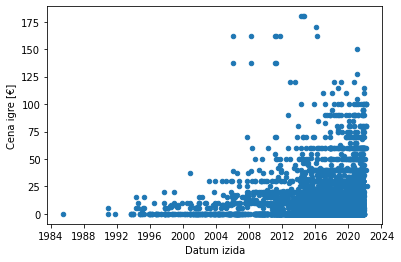

In [81]:
time_price_reviews.plot(x="date", y="cost", kind="scatter", xlabel="Datum izida", ylabel="Cena igre [€]")

<AxesSubplot:xlabel='Datum izida', ylabel='Cena igre [€]'>

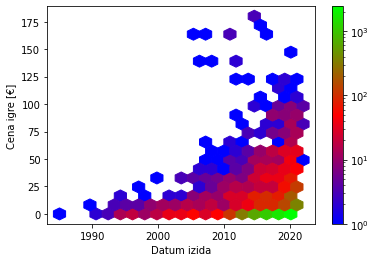

In [82]:
time_price_reviews.plot.hexbin(x="year", y="cost", xlabel="Datum izida", ylabel="Cena igre [€]", gridsize=20, bins="log", cmap="brg", sharex=False)

Na tem grafu lahko zelo lepo vidimo, da cene s časom res naraščajo, in to bolj ali manj linearno. Vidimo sicer nekaj izstopajočih točk, ampak naraščanje je kljub temu zelo lepo vidno.

---
## Napovedovanje oznak igre iz njenega opisa s strojnim učenjem

Do sedaj smo opazovali predvsem medsebojno odvisnost dveh spremenljivk. To nam včasih pomaga pri napovedovanju, ne pa vedno. Kaj pa, če želimo tudi kaj napovedati? Poskusimo ugotoviti, ali lahko iz opisa igre ugotovimo kaj o igri sami, natančneje njene uporabniške oznake.

Za to moramo najprej prečistiti besedilo opisa. Za to bomo uporabili proces Lematiziranja, ki besedo poveže z njeno lemo (izvorno besedo). Ta proces je precej močnejši od preprostega iskanja korena, ker je lema neke besede vedno tudi sama veljavna beseda. Prav tako lema seže čez različne oblike besed, recimo lema pretekle oblike množinskega glagola biti, "were", je sedanjik glagola biti v nedoločniku, "be". Če bi iskali le koren, bi "were" najverjetneje pretvorili v "wer".
Da to dosežemo, bomo uporabili knjižnico `nltk` z `WordNet` korpusom.

Za samo napovedovanje bomo uporabili modele za strojno učenje knjižnice `sklearn`.


In [52]:
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('stopwords')
nltk.download("punkt")
nltk.download('omw-1.4')
wnl = nltk.stem.WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words("english"))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenart.bucar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lenart.bucar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\lenart.bucar\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenart.bucar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenart.bucar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lenart.bucar\AppData\Roaming\nltk_data...


In [53]:
def pos_tagger(nltk_tag):  # funkcija, za prevod POS oznak v wordnet oznake
    if nltk_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

Obstaja več sistemov za označevanje vloge besed v stavku. Knjižnjica `nltk` ima vgrajeno funkcijo za [POS označevanje](https://en.wikipedia.org/wiki/Part_of_speech), mi pa želimo to prevesti na tako označevanje, ki ga podpira `WordNet` korpus.

In [54]:
def lemmatize(sent):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sent))
    wnet_tagged = list(map(lambda w: (w[0], pos_tagger(w[1])), pos_tagged))
    return [wnl.lemmatize(word, tag).lower() if tag is not None else word.lower() for word, tag in wnet_tagged]

def normalise(lemmas: List[str]):
    return sorted({x for x in lemmas if x.isalpha() and x not in stopwords})

def extract(sent: str):
    if sent != sent:
        return []
    return list(normalise(lemmatize(sent)))

sentence = "We were going through the forests on a walk. I saw Jim's dogs tearing apart a wild goose. We're better off leaving them alone."
extract(sentence);

Da se znebimo "ne-besed" (dele po apostrofih, recimo svojina) filtriramo besede, da lahko vsebujejo le črke. Poleg tega izločimo vse nepomembne besede ("stopwords"), kot so na primer "a", "and", "after", "between", "does" in podobno.

In [55]:
keywords = game_data["description"].dropna().apply(lambda x: " ".join(extract(x)))

In [56]:
vectorizer = TfidfVectorizer()
vectorizer.fit(keywords)

TfidfVectorizer()

In [57]:
tags = game_info[game_info["type"] == "T"][["tag"]]
df_tags = pd.get_dummies(pd.DataFrame.from_dict(tags.groupby("id").agg(list)["tag"].to_dict(), orient="index"), prefix="", prefix_sep="")
tags_filterd = df_tags.filter(items=keywords.index, axis=0)
keywords_filterd = keywords.filter(items=tags_filterd.index, axis=0)

Pripravimo podatke za model.

In [58]:
kw_train, kw_test, tags_train, tags_test = train_test_split(keywords_filterd, tags_filterd, test_size=0.1, random_state=1)
kw_train_v = vectorizer.transform(kw_train)
kw_test_v = vectorizer.transform(kw_test)

Podatke ločimo na dva dela. Prvi del podatkov bo uporabljen za trening (tukaj bo to 90% vseh podatkov), preostali del pa bomo uporabili za preverjanje modela. Parameter `random_state` določi seme za naključno razbijanje podatkov in je lahko poljubno celo število. Nastavimo ga, ker bomo natrenirani model spravili, da ga pri ponovnem zagonu ne treniramo še enkrat. Če bi se podatki ob vsakem zagonu naključno ločili, bi se lahko (pri našem razmerju celo skorajda zagotovo) zgodilo, da bi kot testne podatke dobili tiste, na katerih smo model trenirali, kar bi na nepošten način zvišalo natančnost modela.

In [59]:
def train(classifier, force=False, **kwargs):
    filename = f"classifiers/{classifier.__name__}.pickle"
    if os.path.exists(filename) and not force:
        print(f"{filename} exists, loading")
        with open(filename, "rb") as classifier_bkp:
            return pickle.load(classifier_bkp)
    else:
        print(f"{filename} does not exist, training")
        classifier = classifier(**kwargs).fit(kw_train_v, tags_train)
        with open(filename, "wb") as classifier_bkp:
            print("saving")
            pickle.dump(classifier, classifier_bkp)
        return classifier

Ker je treniranje modela računsko zelo draga zadeva, si natreniran model shranimo v lokalno datoteko.
# ***OPOZORILO:*** **knjižnica `pickle` NI varna. Nikoli se ne sme naložiti nobene datoteke, za katero nismo 100% zagotovi, da je prišla iz zanesljivega vira. Tudi v tem primeru se priporoča, da se priložene `.pickle` datoteke izbriše ter model na začetku natrenira na novo.**

In [60]:
def verify_tags(tags: pd.Series):
    pred = set(tags["tags_prediction"])
    test = set(tags["tags_test"])
    tp = pred & test  # true positive
    fp = pred - test  # false positive
    fn = test - pred  # false negative
    # we don't care about true negatives
    tpc = len(tp)
    fpc = len(fp)
    fnc = len(fn)
    return tpc, fpc, fnc, sorted(tp), sorted(fp), sorted(fn)

Za dane predvidene oznake preverimo kako natančne so. Za vsako oznako imamo štiri možnosti:
* True positive - oznaka je bila predvidena in je prisotna tudi v originalnih podatkih
* True negative - oznaka ni bila predvidena in je tudi v originalnih podatkih ni (ta del nas ne zanima)
* False positive - oznaka je bila predvidena, a je v originalnih podatkih ni
* False negative - oznaka ni bila predvidena, v originalnih podatkih pa je prisotna.

Obe zadnji dve kategoriji sta klasificirani kot napaka modela.

In [61]:
def verify_classifier(classifier):
    predictions = pd.DataFrame(classifier.predict(kw_test_v))

    kw_verify = pd.DataFrame(kw_test)
    kw_verify = kw_verify.reset_index()[["id"]].join(predictions).set_index("id")
    kw_verify.columns = tags_test.columns

    tags_prediction = kw_verify[kw_verify == 1].stack().reset_index().drop(0, axis=1).set_index("id").rename(columns = {"level_1": "tags"})
    tags_verification = tags_test[tags_test == 1].stack().reset_index().drop(0, axis=1).rename(columns = {"level_0": "id", "level_1": "tags"}).set_index("id")

    tags_to_verify = pd.merge(
        tags_prediction.groupby("id").agg(pd.Series),
        tags_verification.groupby("id").agg(pd.Series),
        left_index=True,
        right_index=True,
        suffixes=("_prediction", "_test")
    )
    tags_transformed = tags_to_verify.apply(verify_tags, result_type="expand", axis=1)
    tags_transformed.columns = ["true_pos_count", "false_pos_count", "false_neg_count", "true_pos", "false_pos", "false_neg"]
    return tags_transformed

In [62]:
def aggregate(tags):
    return tags[["true_pos_count", "false_pos_count", "false_neg_count"]].mean()

In [63]:
dtc = train(tree.DecisionTreeClassifier)

classifiers/DecisionTreeClassifier.pickle exists, loading


Natreniramo model `DecisionTreeClassifier`, ki je eden izmed redkih modelov, ki sam od sebe podpira več spremenljivk na izhodni strani, kar je to, kar pri tem problemu potrbujemo. Še en podoben model, ki bi ga lahko uporabili, je `RandomForestClassifier` (`sklearn.ensemble.RandomForestClassifier`), ki pa je žal prezahteven za računalnik, ki ga trenutno uporabljam.

In [64]:
dtc_tags = verify_classifier(dtc)
aggregate(dtc_tags)

true_pos_count      4.081712
false_pos_count     9.966926
false_neg_count    12.626459
dtype: float64

Tukaj vidimo povprečno število oznak v vsaki kategoriji. Vidimo, da je število pravilnih napovedi veliko manjše od števila napak, kar ima dve možni razlagi. Prva je, da izbrani model ni dovolj dober za izbrane podatke. To bi lahko preverili tako, da preizkusimo še kakšen drug model in vidimo, ali je razporeditev kaj drugačna. Če bi bila razporeditev (ali več njih) podobna, pa je preostala razlaga preprosto to, da se iz opisa igre njenih oznak ne da napovedati.

Brez treniranja več modelov lahko preštejemo število pojavitev posamezne oznake in vidimo, ali je kakšna oznaka še posebej pogosto pravilna, izpuščena, ali pa napačno predvidena.

In [65]:
def count_tags(tag_list: pd.DataFrame):
    tp = Counter()
    fp = Counter()
    fn = Counter()
    def _count(game_pred):
        tp.update(game_pred["true_pos"])
        fp.update(game_pred["false_pos"])
        fn.update(game_pred["false_neg"])
    tag_list.copy().apply(_count, axis=1)
    return {"true_pos": tp.most_common(5),
            "false_pos": fp.most_common(5),
            "false_neg": fn.most_common(5),
            }

In [66]:
count_tags(dtc_tags)

{'true_pos': [('Singleplayer', 238),
  ('Indie', 162),
  ('Adventure', 161),
  ('Action', 127),
  ('Strategy', 71)],
 'false_pos': [('Indie', 103),
  ('Casual', 95),
  ('2D', 92),
  ('Adventure', 88),
  ('Action', 87)],
 'false_neg': [('Singleplayer', 142),
  ('Indie', 123),
  ('Atmospheric', 113),
  ('Action', 109),
  ('Adventure', 102)]}

Vidimo, da se oznake precej prekrivajo. `Singleplayer` je na vrhu pri dveh kategorijah, `indie` med top 2 pri vseh treh. tudi `adventure` in `action` se ponovijo pri vseh treh. To najverjetneje pomeni, da je pravilna druga razlaga, da torej oznake niso prav zelo odvisne od opisa.

---
## Zaključek

V tej projektni nalogi smo pregledali več različnih podatkov o igrah na Steam platformi.

Ugotovili smo, da je razvijalec z najbolje ocenjenimi igrami `Fireproof games`, tisti z najslabše ocenjenimi pa `Round8 Studio`. Pri založnikih si prvo mesto delita `Fireproof Games` in `New Blood Interactive`, Na koncu pa je `NetEase Games Montreal`.

Povezave med številom ocen ter ceno igre nismo našli, prav tako pa ne povezave med deležem pozitivnih ocen ter ceno igre.

Kljub temu, da se veliko igralcev zanaša na oceno kritikov, ko izbirajo igre, se izkaže, da je korelacija med ocenami kritikov ter deležem pozitivnih ocen uporabnikov majhna, le 0.5, v splošnem pa v povprečju igralci igro ocenijo višje kot kritiki, čeprav kritiki redkeje dajejo slabše ocene.

Ob pregledu oznak iger se je izkazalo, da so med igralci priljubljene igre povezane z glasbo, neradi pa imajo take igre, kjer je za polno izkušnjo potrebno doplačati. Videli smo tudi, da podjetja, ki postavljajo starostne omejitve redkeje postavijo mejo pri 6, 11 in 15 letih, najverjetneje zato, ker je naslednja meja le eno leto višje in jo zaradi previdnosti raje postavijo tja.

Ob pregledu podatkov o sistemskih zahtevah je postalo zelo očitno, da Moorov zakon drži. Tako količina priporočenega pomnilnika kot velikost igre na disku s časom naraščata eksponentno. (Če smo natančni, tako narašča zgornja ovojnica grafa, ker razvijalci še vedno izdelujejo igre, ki so manj zahtevne kot bi zmogli računalniki tistega časa.)

Za konec smo s pomočjo strojnega učenja poskusili napovedati ocene iger. Naš model ni bil najbolj uspešen, zato smo sklenili, da oznake iger niso nujno povezane z njihovimi opisi, vsaj ne na način, ki bi ga naš model lahko predvidel.